In [1]:
import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt 
from einops import repeat

from src.toep_gmg import Toep_GMG1D
from src.green_net import GreenNet1D
from src.model import MLP
from src.utils import rl2_error
from src.dataset import load_dataset_1d

In [2]:
def Poisson(pts):
    x = (pts[...,0]+1)/2
    y = (pts[...,1]+1)/2
    return (x+y - (x-y).abs())/2 - x*y

In [3]:
def Cosine(pts):
    x = pts[...,0]
    y = pts[...,1]
    return torch.cos(torch.pi/2 * (x-y).abs())

In [4]:
def Logarithm(pts):
    x = pts[...,0]
    y = pts[...,1]

    return torch.nan_to_num(torch.log((x-y).abs()), neginf=-8)

In [5]:
def Expdecay(pts):
    x = pts[...,0]
    y = pts[...,1]
    r1 = ((x-0.5)**2 + (y-0.5)**2)**0.5
    r2 = ((x+0.5)**2 + (y+0.5)**2)**0.5
    return torch.exp(-r1/0.05) + torch.exp(-r2/0.05)

In [6]:
def DoubleHoles(pts):
    x = pts[...,0]
    y = pts[...,1]
    r1 = ((x-0.1)**2 + (y-0.1)**2)**0.5
    r2 = ((x+0.1)**2 + (y+0.1)**2)**0.5
    return torch.nan_to_num(torch.log(r1), neginf=-8) - torch.nan_to_num(torch.log(r2), neginf=-8)

In [40]:
device = torch.device('cpu')
model = GreenNet1D(n=12, kernel=Expdecay, device=device, sub_num=5)
# model = GreenNet1D(n=12, kernel=Expdecay, device=device, sub_num=5)
# model = GreenNet1D(n=12, kernel=Poisson, device=device, sub_num=5)
# model = GreenNet1D(n=12, kernel=DoubleHoles, device=device, sub_num=5)


In [41]:
data_root = '/workdir/GreenMgNet/dataset'
train_loader, test_loader = load_dataset_1d('logarithm', data_root, 0, bsz=100)
F, U_ref = next(iter(train_loader))
U_ref = torch.squeeze(U_ref).T
F = torch.squeeze(F).T

In [42]:
# F = torch.squeeze(1 - model.grid.x_h**2)
# F = repeat(F, 'n -> n b', b=64)

Evaluation Points Position

In [43]:
# plt.scatter(model.pts[:,0], model.pts[:,1])
# plt.gca().set_aspect('equal')
# print(model.pts.shape)

Ground Truth Kernel Function

In [44]:
model.eval_K()
K_full = model.K_hh
# plt.scatter(model.pts[:,0], model.pts[:,1], c=K_full)
# plt.gca().set_aspect('equal')
# plt.colorbar()

In [45]:
K_full.reshape(4097,4097)[0]

tensor([-8.0000, -7.6246, -6.9315,  ...,  0.6927,  0.6929,  0.6931])

Full Kernel Integral 

In [46]:
U_full = model.full_kint(F)
print(U_full.shape)

torch.Size([4097, 100])


In [47]:
rl2_error(U_full.T, U_ref.T)

tensor(4.6378e-09)

Text(0.5, 1.0, 'output function U')

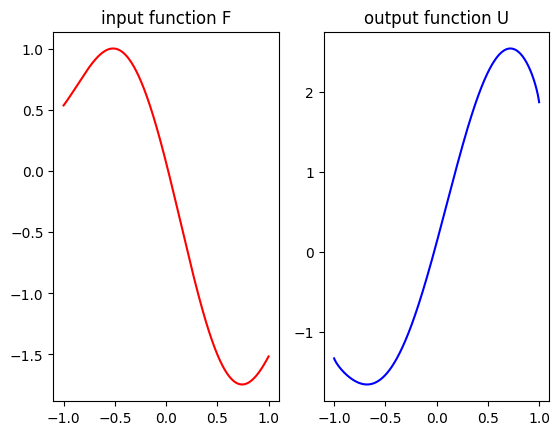

In [48]:
plt.subplot(121)
plt.plot(model.grid.x_h, F[:,0], '-r')
plt.title('input function F')
plt.subplot(122)
plt.plot(model.grid.x_h, U_full[:,0], '-b')
plt.title('output function U')

# Test Eval Batch

In [9]:
model.rand_sub()
print('random sub : ', model.sub)
model.eval_K_sub()
U_sub = model.sub_kint(F)

random sub :  tensor([32, 22, 11, 22, 12])


tensor(3.2345e-08)


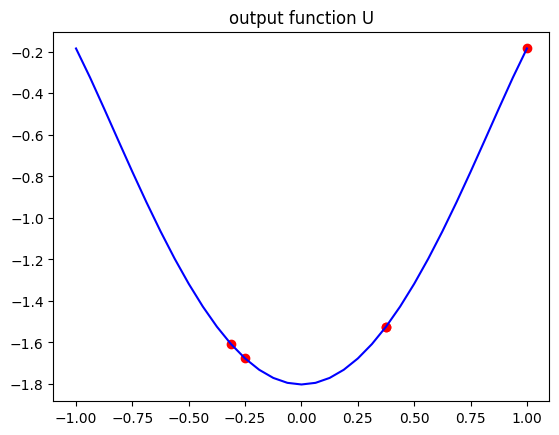

In [10]:
plt.plot(model.grid.x_h, U_full[:,0], '-b')
plt.scatter(model.grid.x_h[model.sub], U_sub[:,0], color='red')
plt.title('output function U')
print(rl2_error(U_sub, U_full[model.sub]))

# Test Batch Kint

In [11]:
model.eval_K_batch(bsz=5)

In [12]:
K_batch = model.K_hh
U_batch = model.batch_kint(F)
print('K rl2 : ' , rl2_error(K_batch, K_full))
print('U rl2 : ' , rl2_error(U_batch, U_full))

K rl2 :  tensor(0.)
U rl2 :  tensor(0.)
